In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df =pd.read_csv('./train.csv')
test_df=pd.read_csv('./test.csv')

In [6]:
df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [7]:
income_map = {'low':1, 'medium':2, 'high':3}
df['facility_rating'] = df['facility_rating'].map(income_map)
#Test Data
test_df['facility_rating'] = test_df['facility_rating'].map(income_map)

In [8]:
income_map = {'easy':1, 'moderate':2, 'hard':3}
df['exam_difficulty'] = df['exam_difficulty'].map(income_map)
#Test Data
test_df['exam_difficulty'] = test_df['exam_difficulty'].map(income_map)

In [9]:
income_map = {'average':2, 'poor':1, 'good':3}
df['sleep_quality'] = df['sleep_quality'].map(income_map)
#Test Data
test_df['sleep_quality'] = test_df['sleep_quality'].map(income_map)

In [10]:
income_map = {'no':0, 'yes':1}
df['internet_access'] = df['internet_access'].map(income_map)
#Test Data
test_df['internet_access'] = test_df['internet_access'].map(income_map)

In [11]:
df.head()
# test_df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,0,4.9,2,online videos,1,1,78.3
1,1,18,other,diploma,4.95,94.8,1,4.7,1,self-study,2,2,46.7
2,2,20,female,b.sc,4.68,92.6,1,5.8,1,coaching,3,2,99.0
3,3,19,male,b.sc,2.00,49.5,1,8.3,2,group study,3,2,63.9
4,4,23,male,bca,7.65,86.9,1,9.6,3,self-study,3,1,100.0


In [12]:
df1 = pd.get_dummies(df, columns=['gender'])
df2 = pd.get_dummies(df1, columns=['study_method'])
df3 = pd.get_dummies(df2, columns=['course'])
df3.head()
test_df1 = pd.get_dummies(test_df, columns=['gender'])
test_df2 = pd.get_dummies(test_df1, columns=['study_method'])
test_df3 = pd.get_dummies(test_df2, columns=['course'])
test_df3.head()

,id,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,gender_female,...,study_method_mixed,study_method_online videos,study_method_self-study,course_b.com,course_b.sc,course_b.tech,course_ba,course_bba,course_bca,course_diploma
0,630000,24,6.85,65.2,1,5.2,1,3,1,False,...,False,False,False,False,False,False,True,False,False,False
1,630001,18,6.61,45.0,0,9.3,1,1,1,False,...,False,False,False,False,False,False,False,False,False,True
2,630002,24,6.60,98.5,1,6.2,3,2,2,True,...,False,False,False,False,False,True,False,False,False,False
3,630003,24,3.03,66.3,1,5.7,2,2,2,False,...,True,False,False,False,False,False,False,False,False,True
4,630004,20,2.03,42.4,1,9.2,2,1,2,True,...,False,False,False,False,False,True,False,False,False,False


In [43]:

X = df3.drop(['exam_score'], axis=1)
# X = df3[['study_hours','class_attendance','sleep_hours','sleep_quality','facility_rating','study_method_coaching']]
y = df3['exam_score']
#Test Data
test_y = test_df3.copy()
# test_y= test_df3[['study_hours','class_attendance','sleep_hours','sleep_quality','facility_rating','study_method_coaching']]

In [82]:
df3.describe()

,id,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,0.919719,7.072758,1.999070,1.985971,1.877679,62.506672
std,181865.479132,2.260238,2.359880,17.430098,0.271728,1.744811,0.823045,0.812399,0.650509,18.916884
min,0.000000,17.000000,0.080000,40.600000,0.000000,4.100000,1.000000,1.000000,1.000000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,1.000000,5.600000,1.000000,1.000000,1.000000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,1.000000,7.100000,2.000000,2.000000,2.000000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,1.000000,8.600000,3.000000,3.000000,2.000000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,1.000000,9.900000,3.000000,3.000000,3.000000,100.000000


In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)
# X_train = X
# y_train = y
# X_test = X
# y_test = y

In [89]:
# model = LinearRegression()
model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=3,
    random_state=42
)
model.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.03, n_estimators=500, random_state=42)

In [90]:
y_pred = model.predict(X_test)
test_predictions = model.predict(test_y)
print(test_predictions)

[72.08571466 70.11167194 87.4594695  ... 89.97940993 55.60516522
 66.35493723]


In [91]:
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R2 Score: 0.7827353095245716
MAE: 7.016185806561724


In [92]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "exam_score": test_predictions
})

In [93]:
submission.to_csv("submission.csv", index=False)

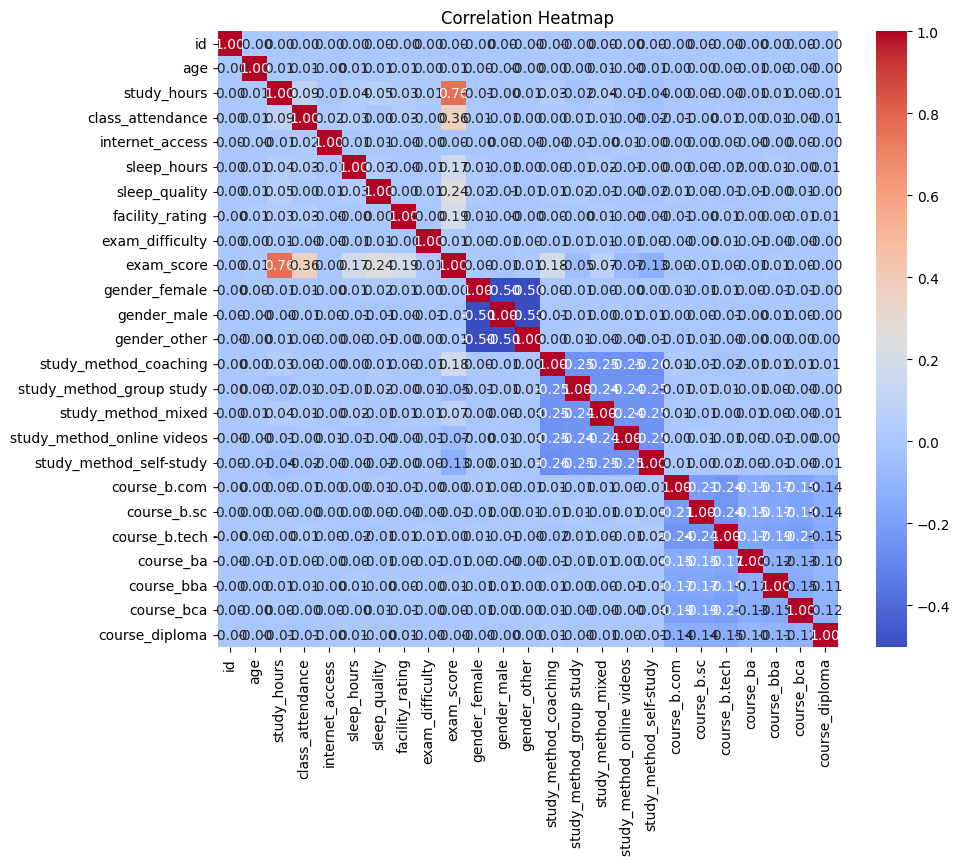

In [20]:
corr = df3.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [58]:
df3.corr()['exam_score']

id                            0.000372
age                           0.010472
study_hours                   0.762267
class_attendance              0.360954
internet_access               0.000447
sleep_hours                   0.167410
sleep_quality                 0.236895
facility_rating               0.188159
exam_difficulty               0.008773
exam_score                    1.000000
gender_female                 0.002101
gender_male                  -0.012403
gender_other                  0.010302
study_method_coaching         0.183712
study_method_group study     -0.051422
study_method_mixed            0.067598
study_method_online videos   -0.071656
study_method_self-study      -0.130269
course_b.com                  0.000759
course_b.sc                  -0.005178
course_b.tech                 0.000353
course_ba                    -0.010823
course_bba                    0.014164
course_bca                    0.001703
course_diploma               -0.001587
Name: exam_score, dtype: 

In [62]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(model.__class__.__name__)
    print("R2 Score :", r2)
    print("MAE      :", mae)
    print("RMSE     :", rmse)
    print("-" * 30)

    return y_pred


In [96]:
models = [
    LinearRegression(),
    Ridge(alpha=1.0),
    Lasso(alpha=0.01),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(n_estimators=100),
    GradientBoostingRegressor()
]

for model in models:
    evaluate_model(model, X_train, X_test, y_train, y_test)

ValueError: could not convert string to float: 'yes'